# Wolt preassignment 2021 
 - - - -


## Overview of process and related files

### Preparation
1. Create postgresql + pgAdmin docker container setup
    - /docker-compose.yml
2. Launch containers with docker-compose up    
3. Login into pgAdmin dashboard 

### SQL
3. Create tables and copy data from csv-files into the tables
    - /sql/1_initialization
    
4. Combine data of the two files into a single table, only include purchase data that is also in first_purchases, format data
    - /sql/2_cleaning
    
5. Create queries which return data needed for cohort analysis
    - /sql/3_processing
    
### Visualization
6. Create jupyter notebook (this file)

7. Connect notebook to the postgresql-container

8. Query data based on queries of part 5. => two distinct queries, one for restaurants another one for retail stores

9. Create dataframes for each, format data for visualization

10. Visualization of cohorts into heatmap using seaborn

### Discussion

11. Answering to assumptions made, problems occurred and speculating about additional business data


***
**SQL dialect used: Postgresql**

**SQL queries are commented with more details in corresponding files in /sql folder.**

**The remaining parts of this notebook consist of visualization of results and discussion.**

***


## Visualization

In [63]:
import pandas as pd                  # to read, format and handle data from queries
import psycopg2                      # connecting db

import seaborn as sns                # visualizing     
import matplotlib.pyplot as plt      #
import matplotlib as mpl             #
import matplotlib.colors as mcolors  #
from matplotlib import cm            #
import numpy as np                   #

In [64]:
# Connecting to dockerized postgres db
# Docker-compose file includes information for connection
conn = psycopg2.connect(
    host="localhost",
    database="db",
    user="root",
    password="root"
)

# Query for restaurants 

sql_r = """
WITH fp_cohorts AS (
	SELECT
		DATE_TRUNC('month', purchase_date) AS cohort_month,
		user_id
	FROM purchases f
	WHERE f.first_buy = True
	AND f.product_line  = 'Restaurant'
	GROUP BY 1, 2
	ORDER BY 1, 2
), monthly_activity AS (
	SELECT 
		user_id,
		(DATE_PART('month', purchase_date) - DATE_PART('month', cohort_month)) AS month_number
	FROM purchases p
	LEFT JOIN fp_cohorts USING(user_id)
	GROUP BY 1, 2
	ORDER BY 1, 2
), cohort_size AS (
	SELECT cohort_month, count(1) AS num_users
	FROM fp_cohorts
	GROUP BY 1
	ORDER BY 1
), retention_table AS (
  SELECT
    C.cohort_month,
    A.month_number,
    count(1) AS num_users
  FROM monthly_activity A
  LEFT JOIN fp_cohorts C USING(user_id)
  GROUP BY 1, 2
)

SELECT
  B.cohort_month,
  S.num_users AS total_users,
  B.month_number::int,
  B.num_users::float * 100 / S.num_users AS percentage
FROM retention_table B
LEFT JOIN cohort_size S USING(cohort_month)
WHERE B.cohort_month IS NOT NULL
ORDER BY 1, 3
"""  

## Query for retail stores
sql_rs = """
WITH fp_cohorts AS (
	SELECT
		DATE_TRUNC('month', purchase_date) AS cohort_month,
		user_id
	FROM purchases f
	WHERE f.first_buy = True
	AND f.product_line  = 'Retail store'
	GROUP BY 1, 2
	ORDER BY 1, 2
), monthly_activity AS (
	SELECT 
		user_id,
		(DATE_PART('month', purchase_date) - DATE_PART('month', cohort_month)) AS month_number
	FROM purchases p
	LEFT JOIN fp_cohorts USING(user_id)
	GROUP BY 1, 2
	ORDER BY 1, 2
), cohort_size AS (
	SELECT cohort_month, count(1) AS num_users
	FROM fp_cohorts
	GROUP BY 1
	ORDER BY 1
), retention_table AS (
  SELECT
    C.cohort_month,
    A.month_number,
    count(1) AS num_users
  FROM monthly_activity A
  LEFT JOIN fp_cohorts C USING(user_id)
  GROUP BY 1, 2
)

SELECT
  B.cohort_month,
  S.num_users AS total_users,
  B.month_number::int,
  B.num_users::float * 100 / S.num_users AS percentage
FROM retention_table B
LEFT JOIN cohort_size S USING(cohort_month)
WHERE B.cohort_month IS NOT NULL
ORDER BY 1, 3
"""  
# Dataframe for restaurants
df_r = pd.read_sql_query(sql_r, conn)

# Dataframe for retail stores
df_rs = pd.read_sql_query(sql_rs, conn)

conn.close()  

In [65]:
df_rs

,cohort_month,total_users,month_number,percentage
0,2020-03-01 00:00:00+00:00,43,0,100.000000
1,2020-03-01 00:00:00+00:00,43,1,20.930233
2,2020-03-01 00:00:00+00:00,43,2,51.162791
3,2020-03-01 00:00:00+00:00,43,3,46.511628
4,2020-03-01 00:00:00+00:00,43,4,37.209302
5,2020-03-01 00:00:00+00:00,43,5,41.860465
6,2020-03-01 00:00:00+00:00,43,6,27.906977
7,2020-03-01 00:00:00+00:00,43,7,18.604651
8,2020-04-01 00:00:00+00:00,81,0,100.000000
9,2020-04-01 00:00:00+00:00,81,1,38.271605


In [66]:
# Change date to more visualizable format
df_r['cohort_month'] = df_r['cohort_month'].dt.to_period('M')
df_rs['cohort_month'] = df_rs['cohort_month'].dt.to_period('M')


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1101: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [67]:
# Lets check that everything looks nice and clean in the table
cohort_pivot_r = df_r.pivot_table(index = ['cohort_month', 'total_users'],
                                columns = 'month_number',
                                values = 'percentage')
cohort_pivot_r

,month_number,0,1,2,3,4,5,6,7
cohort_month,total_users,,,,,,,,
2020-03,8157,100.0,14.245433,36.202035,34.179233,29.312247,28.478607,26.958441,17.984553
2020-04,13851,100.0,27.687532,34.878348,31.232402,28.842683,26.770630,18.569056,NaN
2020-05,10486,100.0,25.729544,34.531757,31.832920,27.436582,18.224299,NaN,NaN
2020-06,9117,100.0,23.297137,34.649556,30.349896,19.260722,NaN,NaN,NaN
2020-07,12829,100.0,22.542677,31.686024,23.283187,NaN,NaN,NaN,NaN
2020-08,12380,100.0,24.353796,23.029079,NaN,NaN,NaN,NaN,NaN
2020-09,4002,100.0,18.515742,NaN,NaN,NaN,NaN,NaN,NaN


In [68]:
cohort_pivot_rs = df_rs.pivot_table(index = ['cohort_month', 'total_users'],
                                columns = 'month_number',
                                values = 'percentage')
cohort_pivot_rs

,month_number,0,1,2,3,4,5,6,7
cohort_month,total_users,,,,,,,,
2020-03,43,100.0,20.930233,51.162791,46.511628,37.209302,41.860465,27.906977,18.604651
2020-04,81,100.0,38.271605,37.037037,32.098765,29.629630,28.395062,22.222222,NaN
2020-05,55,100.0,27.272727,54.545455,36.363636,27.272727,10.909091,NaN,NaN
2020-06,59,100.0,38.983051,47.457627,38.983051,20.338983,NaN,NaN,NaN
2020-07,88,100.0,36.363636,44.318182,25.000000,NaN,NaN,NaN,NaN
2020-08,89,100.0,40.449438,34.831461,NaN,NaN,NaN,NaN,NaN
2020-09,20,100.0,25.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# The SQL currently provides 'total_users' for every row
# Hence we group them by cohort dates, take the first value, and drop unnecassary columns 
# => we end up with months and totals which becomes useful when visualized in next steps


def get_totals_with_month(_df):
    totals_df = _df.groupby('cohort_month').first()
    totals_df.drop(columns=['month_number', 'percentage'], axis=0, inplace=True)
    totals_df.rename(columns={'total_users': "Cohort size"}, inplace=True)
    return totals_df

totals_r = get_totals_with_month(df_r)
totals_rs = get_totals_with_month(df_rs)

In [70]:
# Months & totals!
totals_r

,Cohort size
cohort_month,
2020-03,8157
2020-04,13851
2020-05,10486
2020-06,9117
2020-07,12829
2020-08,12380
2020-09,4002


In [81]:
# We are using same base for both plots, so might aswell make a function
def draw_plot(cohort_table, totals, title, colors="good"):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True,  gridspec_kw={'width_ratios': [1, 11]})


        if colors == "good":
            # Color 1 => Messages the "good areas" more appealing
            color = cm.get_cmap('Greens')
            cmap = mcolors.ListedColormap(color(np.linspace(0.05, 1, 100)))
        
        if colors == "bad":
            # Color 2 => Messages the "bad areas" more appealing
            color = cm.get_cmap('RdYlGn')
            cmap = mcolors.ListedColormap(color(np.linspace(0.05, 0.95, 100)))
        
        # Heatmap
        sns.heatmap(
            cohort_table,
            annot=True,
            fmt='.3g',
            cbar=True,
            ax=ax[1],
            vmin=0, 
            vmax=100,
            cmap=cmap
        )
        for t in ax[1].texts: t.set_text(t.get_text() + "%")
        ax[1].set_title(title, weight='bold', fontsize=20)
        ax[1].set(xlabel='# of periods',
                  ylabel='')

        # Left plot
        white_cmap = mcolors.ListedColormap(['white'])
        
        leftplot = sns.heatmap(totals, 
                    annot=True, 
                    cbar=False, 
                    fmt='g', 
                    cmap=white_cmap, 
                    ax=ax[0],
        )
        ax[0].set(ylabel='')
        leftplot.set_yticklabels(leftplot.get_yticklabels(), rotation=0, size = 12, weight='bold')
        fig.tight_layout()

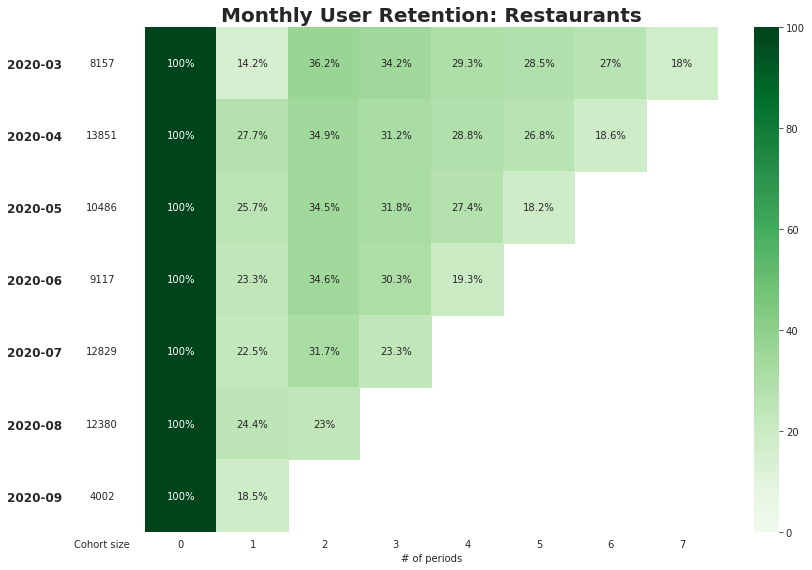

In [82]:
# We use green colors if we wanna highlight the high retention areas, less emphasize on low retention areas
draw_plot(cohort_pivot_r, totals_r,'Monthly User Retention: Restaurants', colors="good")

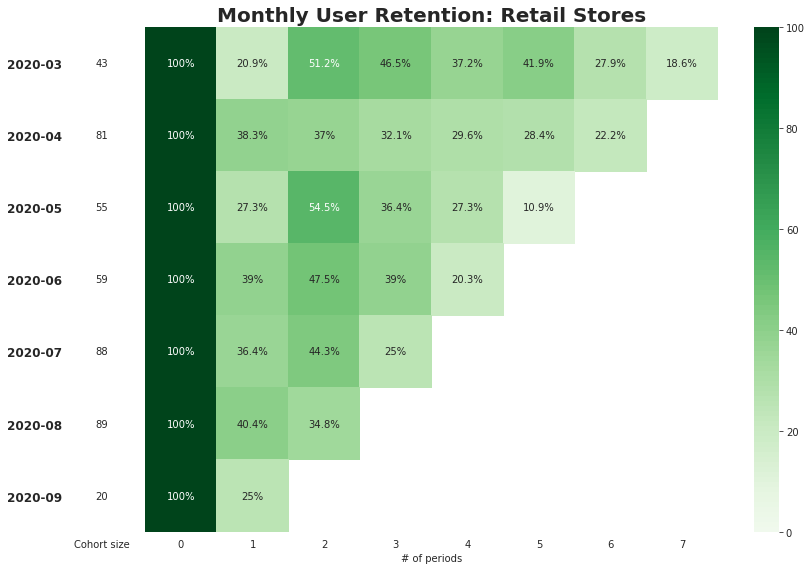

In [83]:
draw_plot(cohort_pivot_rs, totals_rs,'Monthly User Retention: Retail Stores', colors="good")

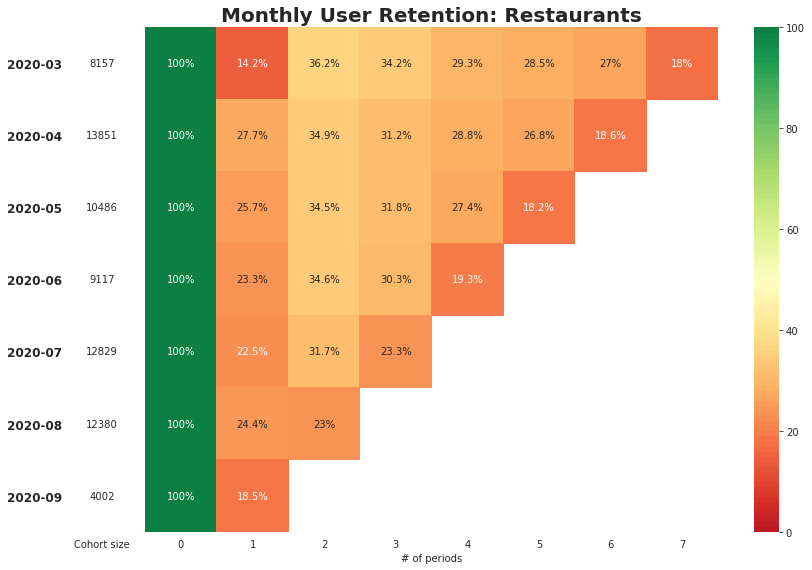

In [84]:
# We use green-to-red colors when we want to give more emphasize on the low-retention areas
draw_plot(cohort_pivot_r, totals_r,'Monthly User Retention: Restaurants', colors="bad")

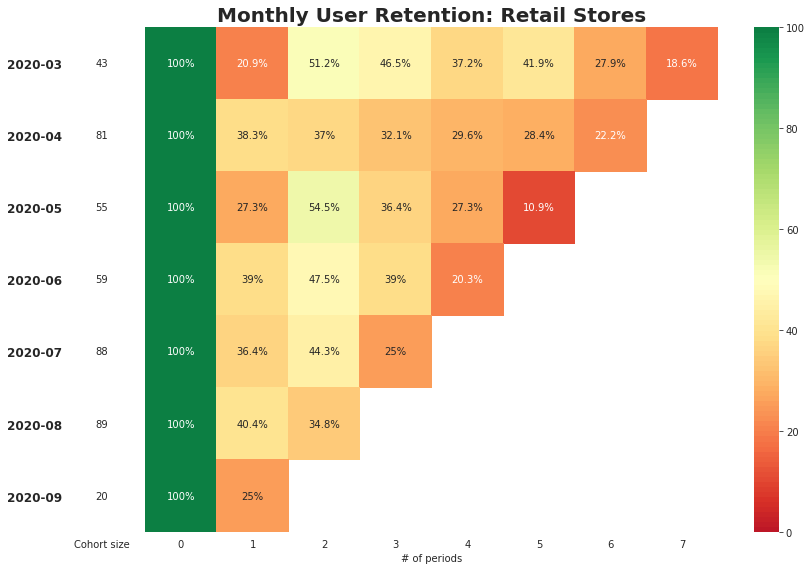

In [85]:
draw_plot(cohort_pivot_rs, totals_rs,'Monthly User Retention: Retail Stores', colors="bad")

## Discussion

### What assumptions about the data did you make when creating your retention charts?

1. We are interested to see how these two product lines differ from each other, and hence the decisions about data must support both of the groups.

2. The cohorts are divided by months. The division could've been also made by two weeks or weekly. Because the total set for retail store cohorts was so low, and the low numbers risked undermining the creditability of our finding, the choose to go with months was made. If the cohort size was bigger, the division between two weeks would've been more feasible visualization wise.

3. Heatmap is especially fit as there are three dimensions to inspects and it provides clear, intuitive explanation to retention numbers monthly.

### Did you encounter any problems in the data?

3. The dates of march began at midway of the month (only half of the purchases that month), and hence the retention numbers are biased. This could've been improved by the division of two weeks, but we chose to go with months because the low cohort sizes of retail stores (check 2.)

4. First purchases of October were not included in the files. We could've assumed that the unique user_ids in purchases which did not exists in first_purchases user_id were new, but this assumption would have been too loose. However, by adding the cohort size for latest month could've provided more insight from decision-making perspective

5. There were items in purchases data which were not included in first purchases, and the dates had to be arranged into date-format, but thats just casual data cleaning.


### Which additional data sources or business information do you think could be used to improve your solution?

6. Filling the data gaps previously mentioned: the purchases of the whole month of march, and distinquishing the first purchases of October.

7. Quantitative marketing data. For instance, the monthly marketing spending could be added to heatmap to identify how campaigns improve the retentions of users. As seen in the both groups, the first period on average has lower retention than second period. For me that sounds strange per se, could it be because retention campaigns are directed to users in the second period? Also the campaigns which include free delivery for 3 first purchases etc could be visualized to understand their effect on retention.

8. Qualitative data. News, exposure, competitor events could be added for the graph to find their relation to retention rates.